First need to load the data in.

In [24]:
import pandas as pd

# --- URL of the SPF Individual CPI file ---
url = ("https://www.philadelphiafed.org/-/media/FRBP/Assets/"
       "Surveys-And-Data/survey-of-professional-forecasters/"
       "data-files/files/Individual_CPI.xlsx")

# --- Read directly from the web ---
df = pd.read_excel(url)

# --- Optional: inspect columns ---
print(df.columns)
print(df.head())

# --- Save as CSV ---
df.to_csv("SPF_Individual_CPI.csv", index=False)

print("CSV saved as SPF_Individual_CPI.csv")

Index(['YEAR', 'QUARTER', 'ID', 'INDUSTRY', 'CPI1', 'CPI2', 'CPI3', 'CPI4',
       'CPI5', 'CPI6', 'CPIA', 'CPIB', 'CPIC'],
      dtype='str')
   YEAR  QUARTER  ID  INDUSTRY  CPI1  CPI2  CPI3  CPI4  CPI5  CPI6  CPIA  \
0  1968        4   1       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1  1968        4   2       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2  1968        4   3       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
3  1968        4   4       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4  1968        4   5       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   CPIB  CPIC  
0   NaN   NaN  
1   NaN   NaN  
2   NaN   NaN  
3   NaN   NaN  
4   NaN   NaN  
CSV saved as SPF_Individual_CPI.csv


/home/clayt/miniconda3/envs/ensemble/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## Exploratory Data Analysis

This section inspects missingness, coverage over time, and how consistently individual forecasters report.


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

data_path = Path("SPF_Individual_CPI.csv")
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Fallback: download from the source URL defined above
    df = pd.read_excel(url)
    df.to_csv(data_path, index=False)

# Normalize blanks to NaN
df = df.replace(r"^\s*$", np.nan, regex=True)

# Cast core columns
df["YEAR"] = pd.to_numeric(df["YEAR"], errors="coerce")
df["QUARTER"] = pd.to_numeric(df["QUARTER"], errors="coerce")
df["ID"] = pd.to_numeric(df["ID"], errors="coerce")

# Identify forecast columns
meta_cols = {"YEAR", "QUARTER", "ID", "INDUSTRY"}
forecast_cols = [c for c in df.columns if c not in meta_cols]

# Convert forecast columns to numeric
for c in forecast_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Basic cleaning
df = df.dropna(subset=["CPI1"])
df = df.sort_values(["YEAR", "QUARTER", "ID"]).reset_index(drop=True)

# Build a period column for time-series analysis (compatible with older pandas)
year_str = df["YEAR"].astype("Int64").astype(str)
qtr_str = df["QUARTER"].astype("Int64").astype(str)
period_str = year_str + "Q" + qtr_str
df["period"] = pd.PeriodIndex(period_str, freq="Q").to_timestamp("Q")

df


,YEAR,QUARTER,ID,INDUSTRY,CPI1,CPI2,CPI3,CPI4,CPI5,CPI6,CPIA,CPIB,CPIC,period
0,1981,3,4,NaN,9.1,8.9000,8.0000,7.6000,7.1000,6.9000,10.1000,7.9000,NaN,1981-09-30
1,1981,3,5,NaN,7.5,9.2000,8.2000,7.3000,7.6000,8.0000,4.9000,7.9000,NaN,1981-09-30
2,1981,3,16,NaN,7.5,9.2000,7.2000,6.5000,6.5000,6.5000,8.7000,6.5000,NaN,1981-09-30
3,1981,3,18,NaN,7.2,9.2000,6.9000,7.5000,8.2000,9.6000,7.4000,8.5000,NaN,1981-09-30
4,1981,3,19,NaN,7.5,11.2000,7.0000,6.5000,6.9000,6.2000,10.1000,7.2000,NaN,1981-09-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6149,2025,4,602,1.0,3.1,3.2018,3.2514,2.6061,2.4334,2.2889,2.9477,2.6443,2.1828,2025-12-31
6150,2025,4,603,2.0,3.1,3.1381,2.4850,2.1465,2.0544,2.0792,2.9064,2.1911,1.9836,2025-12-31
6151,2025,4,607,2.0,3.1,2.9000,2.6000,2.4000,2.6000,2.7000,2.8500,2.5750,2.4000,2025-12-31
6152,2025,4,608,2.0,3.1,3.2000,3.1000,3.0000,2.9000,2.8000,2.9200,2.9500,2.8000,2025-12-31


In [26]:
# Missingness by column
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_rate


CPIC        0.592460
INDUSTRY    0.138447
CPIB        0.069061
CPI6        0.027299
CPIA        0.017712
CPI5        0.005850
CPI2        0.002437
CPI4        0.002112
CPI3        0.002112
QUARTER     0.000000
CPI1        0.000000
ID          0.000000
YEAR        0.000000
period      0.000000
dtype: float64

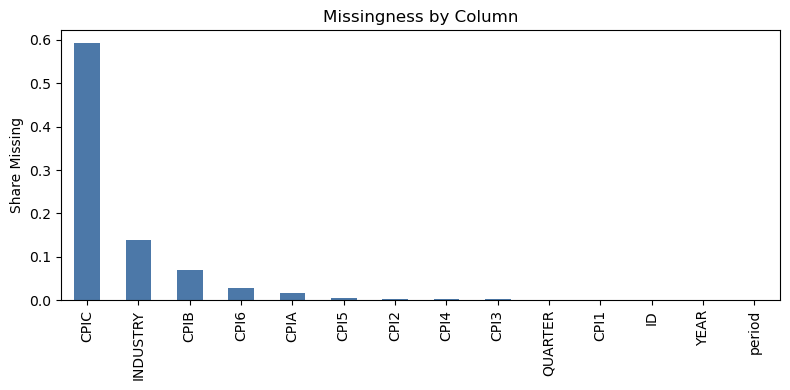

In [27]:
plt.figure(figsize=(8, 4))
missing_rate.plot(kind="bar", color="#4C78A8")
plt.ylabel("Share Missing")
plt.title("Missingness by Column")
plt.tight_layout()
plt.show()


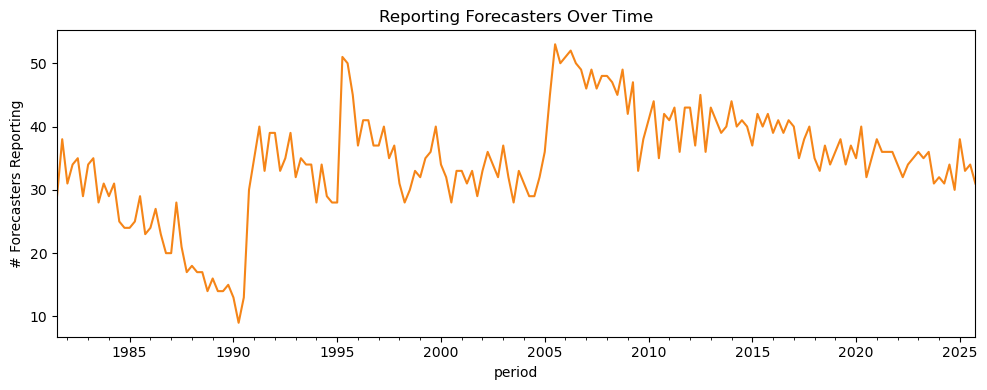

In [28]:
# Count of forecasters reporting per quarter (any non-null forecast)
df["reported_any"] = df[forecast_cols].notna().any(axis=1)

forecasters_per_period = (
    df.loc[df["reported_any"]]
      .groupby("period")["ID"]
      .nunique()
      .sort_index()
)

plt.figure(figsize=(10, 4))
forecasters_per_period.plot(color="#F58518")
plt.ylabel("# Forecasters Reporting")
plt.title("Reporting Forecasters Over Time")
plt.tight_layout()
plt.show()


Total periods: 178
Forecasters with 100% reporting: 0
Forecasters with >=90% reporting: 0
Forecasters with >=75% reporting: 0


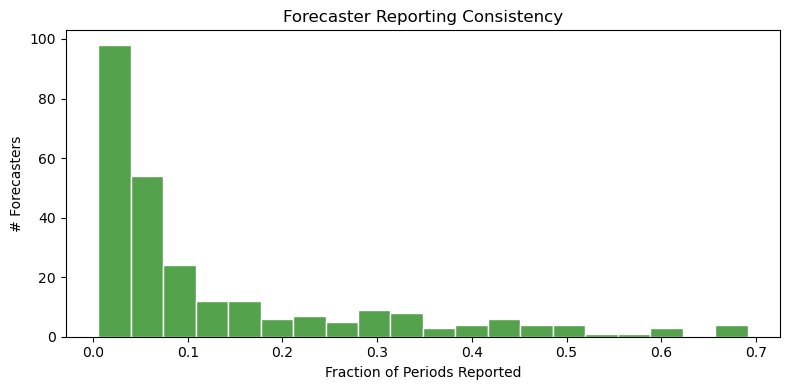

,report_fraction,report_count
ID,,
421,0.691011,123
433,0.691011,123
426,0.679775,121
411,0.668539,119
428,0.595506,106
463,0.595506,106
484,0.595506,106
510,0.578652,103
518,0.528090,94


In [29]:
# Consistency: fraction of periods in which each forecaster reports
total_periods = df["period"].nunique()
report_counts = (
    df.groupby("ID")["reported_any"]
      .sum()
      .sort_values(ascending=False)
)

report_fraction = report_counts / total_periods

print(f"Total periods: {total_periods}")
print(f"Forecasters with 100% reporting: {(report_fraction == 1).sum()}")
print(f"Forecasters with >=90% reporting: {(report_fraction >= 0.9).sum()}")
print(f"Forecasters with >=75% reporting: {(report_fraction >= 0.75).sum()}")

# Distribution of reporting consistency
plt.figure(figsize=(8, 4))
plt.hist(report_fraction, bins=20, color="#54A24B", edgecolor="white")
plt.xlabel("Fraction of Periods Reported")
plt.ylabel("# Forecasters")
plt.title("Forecaster Reporting Consistency")
plt.tight_layout()
plt.show()

# Most consistent forecasters (top 10 by reporting fraction, then count)
top_consistent = (
    pd.DataFrame({"report_fraction": report_fraction, "report_count": report_counts})
      .sort_values(["report_fraction", "report_count"], ascending=False)
      .head(10)
)
top_consistent


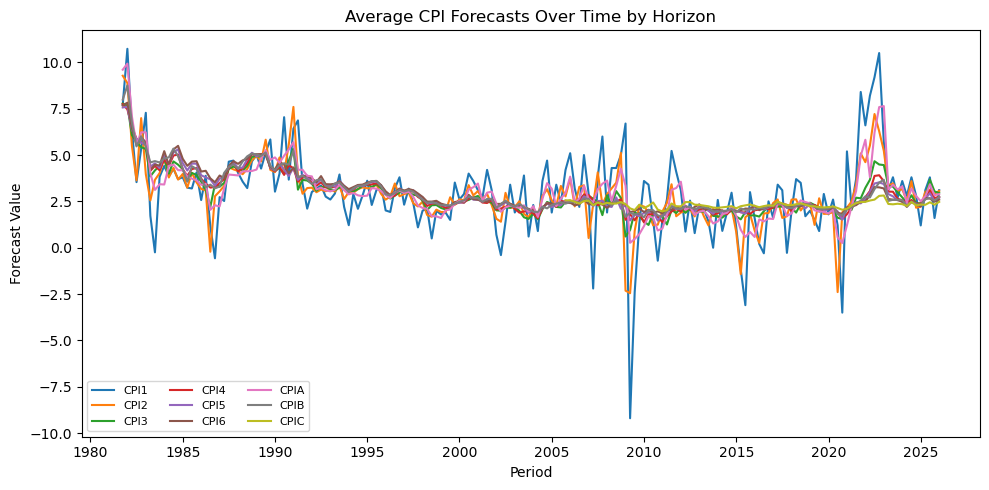

In [30]:
# Forecasts over time: average by horizon across forecasters
avg_by_period = df.groupby("period")[forecast_cols].mean().sort_index()

plt.figure(figsize=(10, 5))
for c in forecast_cols:
    plt.plot(avg_by_period.index, avg_by_period[c], label=c)

plt.title("Average CPI Forecasts Over Time by Horizon")
plt.ylabel("Forecast Value")
plt.xlabel("Period")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()


TypeError: Image data of dtype object cannot be converted to float

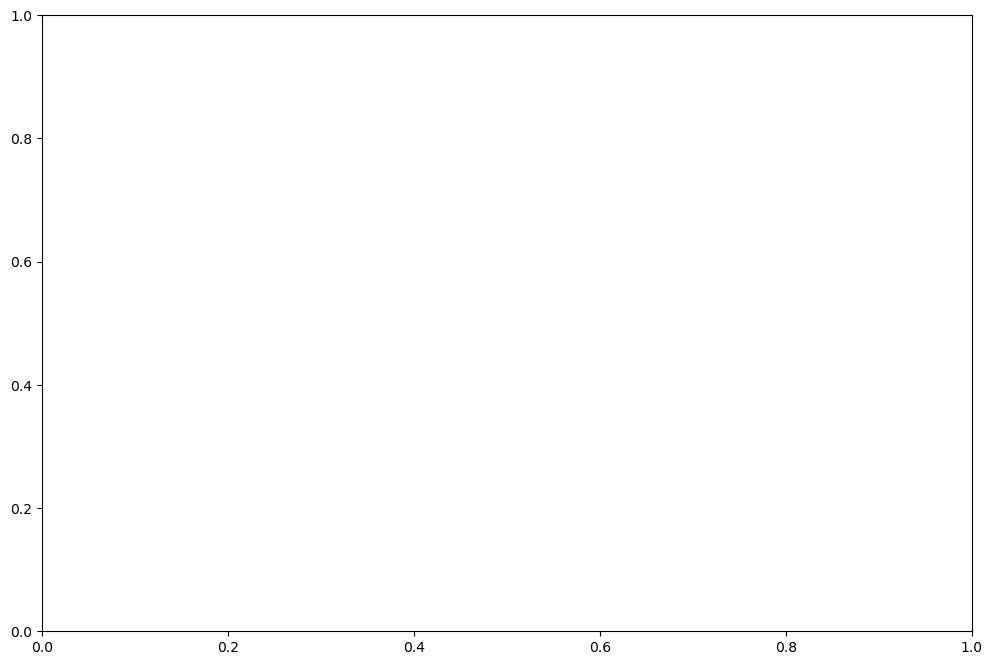

In [31]:
# Waterfall-style plot: forecaster reporting over time (ID x period)
# 1 = reported any forecast in that period, 0 = missing
report_matrix = (
    df.assign(reported_any=df[forecast_cols].notna().any(axis=1))
      .pivot_table(index="ID", columns="period", values="reported_any", aggfunc="max")
      .fillna(0)
)

# Sort forecasters by overall reporting rate (most consistent at top)
report_matrix = report_matrix.loc[report_matrix.mean(axis=1).sort_values(ascending=False).index]

# Prepare labels
period_labels = report_matrix.columns.to_period('Q').astype(str)

plt.figure(figsize=(12, 8))
plt.imshow(report_matrix.to_numpy(dtype=float), aspect="auto", interpolation="nearest", cmap="Greys")
plt.colorbar(label="Reported (1=yes)")
plt.title("Forecaster Reporting Over Time (Waterfall)")
plt.xlabel("Period")
plt.ylabel("Forecaster ID (sorted by reporting rate)")

# Show a subset of x-ticks for readability
if report_matrix.shape[1] > 12:
    step = max(1, report_matrix.shape[1] // 12)
    xticks = list(range(0, report_matrix.shape[1], step))
    plt.xticks(xticks, [period_labels[i] for i in xticks], rotation=45)
else:
    plt.xticks(range(report_matrix.shape[1]), period_labels, rotation=45)

plt.yticks([])
plt.tight_layout()
plt.show()
